In [10]:
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from scipy.signal import convolve2d
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

np.set_printoptions(precision=3, suppress=True)

import time
from matplotlib.colors import ListedColormap

import cProfile

In [2]:
np.random.seed(seed=123)

In [ ]:
%matplotlib notebook
N = 100
np.random.RandomState(2)
pDeath = 0.2
wDead = 11
wRepl = 1
wBoost = 100
replMatrix = np.array([[0,1,0],[1,0,1],[0,1,0]])
boostMat = np.array([[1,0,1],[1,0,1],[0,0,0]])
boostMats = [np.rot90(boostMat, k = rotId) for rotId in range(4)]
dIJs =[
    (0, 1) , # top
    (1, 0), # left
    (2, 1),  # bottom
    (1, 2)   # right
] # where is the replication coming from?
nSpecies = 5
speciesIds = np.arange(1,nSpecies+1, dtype = int)
cmap = "turbo"
my_cmap = plt.get_cmap(cmap)
colors = my_cmap(np.arange(0,nSpecies)) 


lattice = np.zeros((N,N), dtype = int)
initDistribution = np.random.choice(speciesIds, size = N*N)
initLattice = initDistribution.reshape(N,N)

Rsq = N**2/2/np.pi 
seedIs = []
seedJs = []
for i in range(N):
    for j in range(N):
        if (N/2 - i)**2 + (N/2 - j)**2 > Rsq:
            seedIs.append(i)
            seedJs.append(j)

initLattice[seedIs,seedJs] = 0 
lattice = initLattice.astype(int)

def pbc(x):
    global N
    if x >= N:
        return x - N 
    if x < 0:
        return x + N
    else: return x






###############################################################
# plotting 
###############################################################


fig, ax = plt.subplots(1, 2,
                       figsize = (8,4),
                       dpi = 100,
                        gridspec_kw=dict(width_ratios=[5, 1], 
                     wspace=0.2)
                      )

im1=ax[0].imshow(initLattice, 
                interpolation='none', 
              cmap = cmap
             )
im2=ax[1].bar(x = range(nSpecies + 1), 
              height = [5]*(nSpecies+1), 
              color = colors)



def init():
    im1 = plt.imshow(np.zeros(N,N))
    im2 = plt.bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)
    return [im1, im2]


def animate(i):
    global lattice

    newLattice = np.zeros((N, N), dtype = int)

    r = np.random.uniform(size = (N, N))
    survivedIds = np.logical_and(lattice != 0, r >= pDeath)

    diedIds = np.logical_and(lattice != 0, r < pDeath)
    #lattice[diedIds] = 0
    emptyAndReplicatingIds = np.where( # double check this
        np.logical_and(
           # np.logical_or(lattice == 0, diedIds), # empty or just died
            lattice == 0, # just empty
            convolve2d(lattice != 0, replMatrix,
                       mode = "same", boundary="wrap"
                          )
            )
        )
    ax[0].set_title("$N_{repl}$" + f" = {len(emptyAndReplicatingIds[0])}")
    for i,j in zip(*emptyAndReplicatingIds):
        neighbors = np.pad(lattice, 1, mode='wrap')[i:i+3, j:j+3]
        aliveNeighIds = np.where(neighbors * replMatrix > 0)

        claims = np.zeros(nSpecies+1)
        claims[0] = wDead
        
        for iN,jN in zip(*aliveNeighIds):
            s = neighbors[iN,jN]
            claims[s] += wRepl # claims for this empty cell from valid neighbor s at iN,jN 
            sBoost = s - 1
            if sBoost == 0:
                sBoost = nSpecies
            rotId = dIJs.index((iN,jN))
            #boost = (boostMats[rotId] * (neighbors == sBoost)).sum()     
            boost = np.einsum('ij,ij',boostMats[rotId], neighbors == sBoost)
            claims[s] += wBoost * boost

        cumProb = np.cumsum(claims) / claims.sum()
        rr = np.random.uniform()
        newCell = np.argmax(cumProb > rr)
        newLattice[i, j] = newCell

    newLattice[survivedIds] = lattice[survivedIds]

    lattice = newLattice.copy()
    ############################
    # plotting
    ############################

    im1.set_array(lattice)
    
    ccc = Counter(newLattice.flatten())
    for s in range(nSpecies+1):
        if not s in ccc:
            ccc[s] = 0
        
    vvv = [v for k,v in sorted([(k,v) for k,v in ccc.items()])]
    for rect, h in zip(im2, vvv):
        rect.set_height(h)
    ax[1].set_ylim(0, 1.05*max(vvv))
        
   
    return [im1, im2]

ani = FuncAnimation(fig, animate, frames=20000, interval=1,
                    #cache_frame_data = True,
                    blit=False
                   )

### attempt at vectorization


In [ ]:
np.unravel_index()

In [70]:
def fillNewLattice(neighbors):
    neighbors = neighbors.reshape(3,3)
    aliveNeighIds = np.where(neighbors * replMatrix > 0)

    claims = np.zeros(nSpecies+1)
    claims[0] = wDead

    for iN,jN in zip(*aliveNeighIds):
        s = neighbors[iN,jN]
        #claims[s] = np.sum(claims[s] + wRepl) # claims for this empty cell from valid neighbor s at iN,jN 
        claims[s] += wRepl # claims for this empty cell from valid neighbor s at iN,jN 

        sBoost = s - 1
        if sBoost == 0:
            sBoost = nSpecies
        rotId = dIJs.index((iN,jN))
        boost = (boostMats[rotId] * neighbors == sBoost).sum()
        #boost = np.einsum('ij,ij', boostMats[rotId], neighbors == sBoost)

        claims[s] += wBoost * boost

    cumProb = np.cumsum(claims) / claims.sum()
    rr = np.random.uniform()

    newCell = np.argmax(cumProb > rr)
    return newCell

cProfile.runctx( '[fillNewLattice(np.random.choice(range(nSpecies), size = 9).reshape((3,3))) for i in range(5000)]', globals(),locals() )

         290860 function calls in 0.501 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     5000    0.144    0.000    0.310    0.000 635800111.py:1(fillNewLattice)
     5000    0.004    0.000    0.024    0.000 <__array_function__ internals>:177(argmax)
     5000    0.004    0.000    0.031    0.000 <__array_function__ internals>:177(cumsum)
    10000    0.007    0.000    0.097    0.000 <__array_function__ internals>:177(prod)
     5000    0.003    0.000    0.014    0.000 <__array_function__ internals>:177(where)
        1    0.013    0.013    0.501    0.501 <string>:1(<listcomp>)
        1    0.000    0.000    0.501    0.501 <string>:1(<module>)
    22714    0.006    0.000    0.059    0.000 _methods.py:46(_sum)
     5000    0.001    0.000    0.001    0.000 fromnumeric.py:1123(_argmax_dispatcher)
     5000    0.006    0.000    0.017    0.000 fromnumeric.py:1127(argmax)
     5000    0.001    0.000    0.001    0.000 fromnumeri

In [347]:
speciesIds

array([1, 2, 3])

In [550]:
N = 3
lattice = np.random.choice(range(nSpecies+1), N*N).reshape((N,N))
lattice

array([[1, 0, 2],
       [4, 1, 3],
       [3, 4, 1]])

In [551]:
np.roll(lattice, shift=1, axis=0)

array([[3, 4, 1],
       [1, 0, 2],
       [4, 1, 3]])

In [521]:
np.roll(down, shift=1, axis=(0,1)

SyntaxError: incomplete input (1783281060.py, line 1)

In [570]:
def computeNeighbours(lattice):
    # Compute wrapped neighbors using numpy's roll function
    down = np.roll(lattice, shift=-1, axis=0)
    up = np.roll(lattice, shift=1, axis=0)
    right = np.roll(lattice, shift=-1, axis=1)
    left = np.roll(lattice, shift=1, axis=1)
    
    down_right = np.roll(down, shift=-1, axis=1)
    down_left = np.roll(down, shift=1, axis=1)
    up_right = np.roll(up, shift=-1, axis=1)
    up_left = np.roll(up, shift=1, axis=1)

    # Stack neighbors along a new last dimension
    # So that neighbors[..., 0] is "up", neighbors[..., 1] is "left", etc.
    return np.stack([up, left, down, right, up_left, up_right, down_left, down_right], axis=-1)

def onehot(a):
    ncols = nSpecies+1
    out = np.zeros( (a.size,ncols), dtype=np.uint8)
    out[np.arange(a.size),a.ravel()] = 1
    out.shape = a.shape + (ncols,)
    return out

def fillNewLattice(lattice, neighbors_matrix):
    # Initialize claims for the entire lattice
    claims = np.zeros((N, N, nSpecies+1), dtype=np.uint16) # i,j,s

    # Calculate the claims from the neighbors for each direction in dIJs
    # replicator direction dIJs = [(0, 1), (1, 0), (2, 1), (1, 2)]
    #                               up,     left,  down,   right 
    replicationDirectionShifts = {(0, 1):"up", (1, 0):"left", (2, 1):"down", (1, 2):"right"}

    boostLogic = {
        "up": [4,5,1,3],
        "left": [4,6,0,2],
        "down": [6,7,1,3],
        "right": [5,7,0,2],
    }
    
    
    # for each possible replication direction
    for replicationDirectionId, replicationDirectionShift in enumerate(replicationDirectionShifts.values()):
        replicationDirectionName = replicationDirectionShift # for boosting logic
        replicatorSpecies = neighbors_matrix[..., replicationDirectionId]
        
        boosterSpeciesRequired = replicatorSpecies + 1
        boosterSpeciesRequired[boosterSpeciesRequired > nSpecies] = 1

        claims += wRepl * onehot(replicatorSpecies)
        
        for boostDirectionId in boostLogic[replicationDirectionName]:
            boosterSpecies = neighbors_matrix[..., boostDirectionId]
            correctBoosterSpecies = boosterSpecies * (boosterSpecies == boosterSpeciesRequired)
            claims += wBoost * onehot(correctBoosterSpecies)
    
    # Normalize claims and pick new cells
    claims[..., 0] = wDead
    cumProb = np.cumsum(claims, axis=-1) / claims.sum(axis=-1, keepdims=True)
    rr = np.random.uniform(size=(N, N, 1))
    
    ###### THIS DOES NOT RESOLVE EQUAL CLAIMS!!! FIX!!!
    new_cells = (cumProb > rr).argmax(axis=-1) # probabilistic
    #new_cells = (claims).argmax(axis=-1) # deterministic

    # TODO:
    # 1. get cells with equal claims 
    # 2. select random cells from those with equal claims
    
    return new_cells

    

### GPT

<IPython.core.display.Javascript object>


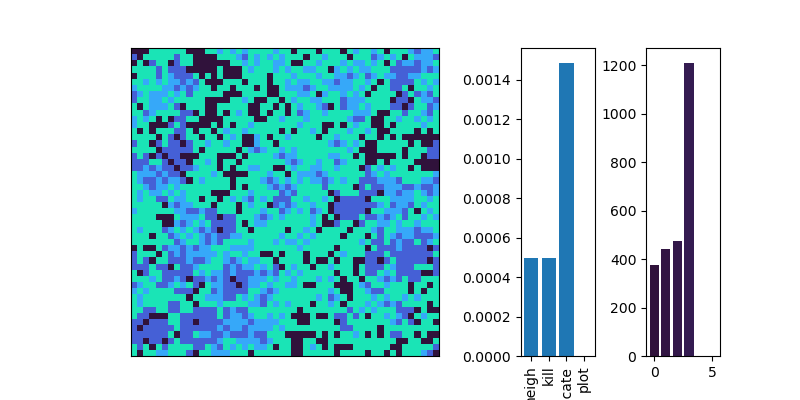

In [574]:
%matplotlib notebook

import numpy as np
from scipy.signal import convolve2d

timers = {
    "neigh":0,
    "kill":0,
    "replicate":0,
    "plot":0, 
}


N =50
pDeath = 0.2
wDead = 11
wRepl = 1
wBoost = 100
replMatrix = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

nSpecies = 5
speciesIds = np.arange(1, nSpecies + 1, dtype=int)

# Initialization
lattice = np.zeros((N, N), dtype=int)
initDistribution = np.random.choice(speciesIds, size=N * N).reshape(N, N)

Rsq = N**2 / 2 / np.pi
seed_mask = (np.indices((N, N)).T - N / 2)**2.0
seed_mask = seed_mask[:, :, 0] + seed_mask[:, :, 1] > Rsq
initDistribution[seed_mask] = 0
lattice = initDistribution.astype(np.uint8)


def animate(i):
    global lattice
    
    start = time.time()
    
    neighbors = computeNeighbours(lattice)
    
    stop = time.time()
    timers["neigh"] = stop - start
    
    start = time.time()
    
    survived_mask = np.random.uniform(size=lattice.shape) > pDeath
    died_mask = np.logical_not(survived_mask)
    lattice[died_mask] = 0

    replication_mask = (convolve2d(lattice > 0, replMatrix, mode="same", boundary="wrap") > 0)
    replication_spots = np.logical_and(lattice == 0, replication_mask)
    
    stop = time.time()
    timers["kill"] = stop - start    
    
    start = time.time()
    lattice[replication_spots] = fillNewLattice(lattice, neighbors)[replication_spots]

    lattice[survived_mask] = lattice[survived_mask]
    stop = time.time()
    timers["replicate"] = stop - start
    ############################
    # plot
    ############################
    start = time.time()

    im1.set_array(lattice)

    timerHeights = []
    for rect, h in zip(im2, [v for v in timers.values()]):
        rect.set_height(h)
        timerHeights.append(h)
    ax[1].set_ylim(0, 1.05*max(timerHeights))
    
    
    stop = time.time()
    timers["plot"] = stop - start
    
    
    ccc = Counter(lattice.flatten())
    for s in range(nSpecies+1):
        if not s in ccc:
            ccc[s] = 0
        
    vvv = [v for k,v in sorted([(k,v) for k,v in ccc.items()])]
    for rect, h in zip(im3, vvv):
        rect.set_height(h)
        
    ax[2].set_ylim(0, 1.05*max(vvv))
    
    return [im1, im2, im3]



fig, ax = plt.subplots(1, 3,
                       figsize = (8,4),
                       dpi = 100,
                        gridspec_kw=dict(width_ratios=[5, 1, 1], 
                     wspace=0.3)
                      )

im1=ax[0].imshow(initLattice, 
                interpolation='none', 
              cmap = cmap
             )
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
im2=ax[1].bar(x = range(1,1+len(timers)), height = [0.2]*len(timers))
ax[1].set_xticks(range(1,1+len(timers)))
ax[1].set_xticklabels(timers.keys(), rotation = 90)

im3=ax[2].bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)
def init():
    im1 = plt.imshow(np.zeros(N,N))
    im2 = plt.bar(x = range(1,1+len(timers)), height = [0.2]*len(timers), )
    im3 = plt.bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), colors = colors)
    return [im1, im2, im3]
ani = FuncAnimation(fig, animate, frames=20000, interval=15,
                    #cache_frame_data = True,
                    blit=False
                   )    
    
    





In [197]:
animate(2)

 <BarContainer object of 5 artists>,
 <BarContainer object of 4 artists>]

In [78]:
compute_neighbours(lattice).shape

(150, 150, 5)

In [152]:
def compute_neighbours(lattice):
    # Compute wrapped neighbors more efficiently
    top = np.roll(lattice, 1, axis=0)
    bottom = np.roll(lattice, -1, axis=0)
    left = np.roll(lattice, 1, axis=1)
    right = np.roll(lattice, -1, axis=1)

    topLeft = np.roll(lattice, (1,1), axis=0)
    bottomLeft = np.roll(lattice,(-1, -1), axis=0)
    topRight = np.roll(lattice, (1,1), axis=0)
    bottomRight = np.roll(lattice, (-1,1), axis=1)

    return np.stack([[topLeft, top, topRight],[left, left, right,], [bottomLeft, bottom, bottomRight]], axis = -1)

times = []
start = time.time()
for i in range(10):
    compute_neighbours(lattice)
print(time.time() - start)

# def compute_neighbours2(lattice):
#     neighLattice = np.zeros((N,N,3*3))
#     for i in range(N):
#         for j in range(N):
#             neighLattice[i,j] = np.pad(lattice, 1, mode='wrap')[i:i+3, j:j+3].flatten()
            
# times = []
# start = time.time()
# for i in range(10):
#     compute_neighbours2(lattice)
# print(time.time() - start)

0.0034720897674560547


In [153]:
asd =     compute_neighbours(lattice)

In [154]:
asd.shape

(3, 150, 150, 3)

In [155]:
asd[0][1][1]

array([0, 0, 0])

In [88]:
j

999

In [96]:
tmpNeighborVec

NameError: name 'tmpNeighborVec' is not defined

<IPython.core.display.Javascript object>


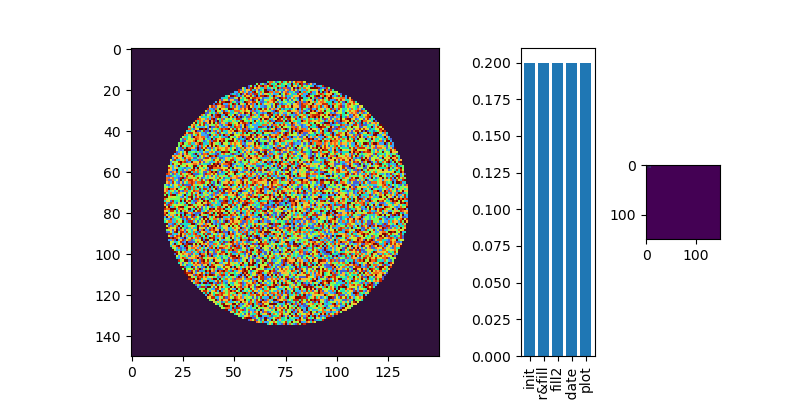

In [131]:
%matplotlib notebook
N = 150
np.random.RandomState(2)
pDeath = 0.2
wDead = 11
wRepl = 1
wBoost = 100
replMatrix = np.array([[0,1,0],[1,0,1],[0,1,0]])
boostMat = np.array([[1,0,1],[1,0,1],[0,0,0]])
boostMats = [np.rot90(boostMat, k = rotId) for rotId in range(4)]
dIJs =[
    (0, 1) , # top
    (1, 0), # left
    (2, 1),  # bottom
    (1, 2)   # right
] # where is the replication coming from?
nSpecies = 9
speciesIds = np.arange(1,nSpecies+1, dtype = int)
cmap = "turbo"
my_cmap = plt.get_cmap(cmap)
colors = my_cmap(np.arange(0,nSpecies)) 


lattice = np.zeros((N,N), dtype = int)
initDistribution = np.random.choice(speciesIds, size = N*N)
initLattice = initDistribution.reshape(N,N)

Rsq = N**2/2/np.pi 
seedIs = []
seedJs = []
for i in range(N):
    for j in range(N):
        if (N/2 - i)**2 + (N/2 - j)**2 > Rsq:
            seedIs.append(i)
            seedJs.append(j)

initLattice[seedIs,seedJs] = 0 
lattice = initLattice.astype(int)

def pbc(x):
    global N
    if x >= N:
        return x - N 
    if x < 0:
        return x + N
    else: return x

###############################################################
# plotting 
###############################################################
timers = {
    "init":0,
    "constr&fill":0,
    "fill2":0,
    "update":0,
    "plot":0,
    
}


fig, ax = plt.subplots(1, 3,
                       figsize = (8,4),
                       dpi = 100,
                        gridspec_kw=dict(width_ratios=[5, 1, 1], 
                     wspace=0.3)
                      )

im1=ax[0].imshow(initLattice, 
                interpolation='none', 
              cmap = cmap
             )

im2=ax[1].bar(x = range(1,1+len(timers)), height = [0.2]*len(timers))
ax[1].set_xticks(range(1,1+len(timers)))
ax[1].set_xticklabels(timers.keys(), rotation = 90)

im3=ax[2].bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)


def init():
    im1 = plt.imshow(np.zeros(N,N))
    im2 = plt.bar(x = range(1,1+len(timers)), height = [0.2]*len(timers), )
    im3 = plt.bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), colors = colors)
    return [im1, im2, im3]

def compute_neighbours(lattice):
    # Compute wrapped neighbors more efficiently
    top = np.roll(lattice, 1, axis=0)
    bottom = np.roll(lattice, -1, axis=0)
    left = np.roll(lattice, 1, axis=1)
    right = np.roll(lattice, -1, axis=1)

    topLeft = np.roll(lattice, 1, axis=0)
    bottomLeft = np.roll(lattice, -1, axis=0)
    topRight = np.roll(lattice, 1, axis=0)
    bottomRight = np.roll(lattice, -1, axis=(0,1))

    return np.stack([[topLeft, top, topRight],[left, left, right,], [bottomLeft, bottom, bottomRight]], axis = -1)

def fillNewLattice(neighbors):
    neighbors = neighbors.reshape(3,3)
    aliveNeighIds = np.where(neighbors * replMatrix > 0)

    claims = np.zeros(nSpecies+1)
    claims[0] = wDead

    for iN,jN in zip(*aliveNeighIds):
        s = neighbors[iN,jN]
        claims[s] += wRepl # claims for this empty cell from valid neighbor s at iN,jN 
        sBoost = s - 1
        if sBoost == 0:
            sBoost = nSpecies
        rotId = dIJs.index((iN,jN))
        boost = np.einsum('ij,ij', boostMats[rotId], neighbors == sBoost)
        claims[s] += wBoost * boost

    cumProb = np.cumsum(claims) / claims.sum()
    rr = np.random.uniform()

    newCell = np.argmax(cumProb > rr)
    return newCell
    

    
def animate(a):
    global lattice
    ##########################
    # init
    ##########################
    start = time.time()

    newLattice = np.zeros((N, N), dtype = int)
    
    r = np.random.uniform(size = (N, N))
    survivedIds = np.logical_and(lattice != 0, r >= pDeath)
    diedIds = np.logical_and(lattice != 0, r < pDeath)
    lattice[diedIds] == 0
    emptyAndReplicatingIds = np.where( # double check this
        np.logical_and(
            np.logical_or(lattice == 0, diedIds),
            #lattice == 0, # just empty
            #diedIds,
            convolve2d(lattice != 0, replMatrix,
                       mode = "same", boundary="wrap"
                          )
            )
        )
    
    idxList = np.array([a for a in enumerate(zip(*emptyAndReplicatingIds))]) # enumerated coordinates of replicators

    nReplicators = len(emptyAndReplicatingIds[0])
    rr = np.random.uniform(size = nReplicators)
    
    neighborVec = np.zeros((nReplicators, 3*3), dtype = int)
    stop = time.time()
    timers["init"] = stop - start
    
    ##########################
    # construct
    ##########################
    start = time.time()
    
    
    tmpNeighborVec = compute_neighbours(lattice)
    neighborVec = np.zeros((nReplicators,3,3))
    neighborVec = tmpNeighborVec[emptyAndReplicatingIds]
     #neighborVec[n] = np.pad(lattice, 1, mode='wrap')[i:i+3, j:j+3].flatten() 
        
    ax[0].set_title("$N_{repl}$" + f"= {nReplicators}")
    

    
    ##########################
    # fill
    ##########################
    newLatticeValuesFlat = np.apply_along_axis(fillNewLattice, 1, neighborVec)
    for n,(i,j) in idxList:
        newLattice[i,j] = newLatticeValuesFlat[n] 
    stop = time.time()
    timers["constr&fill"] = stop - start
    

    newLattice[survivedIds] = lattice[survivedIds]

    lattice = newLattice.copy()
  
    
    ############################
    # plot
    ############################
    start = time.time()

    im1.set_array(lattice)

    timerHeights = []
    for rect, h in zip(im2, [v for v in timers.values()]):
        rect.set_height(h)
        timerHeights.append(h)
    ax[1].set_ylim(0, 1.05*max(timerHeights))
    
    
    stop = time.time()
    timers["plot"] = stop - start
    
    
    ccc = Counter(newLattice.flatten())
    for s in range(nSpecies+1):
        if not s in ccc:
            ccc[s] = 0
        
    vvv = [v for k,v in sorted([(k,v) for k,v in ccc.items()])]
    for rect, h in zip(im3, vvv):
        rect.set_height(h)
        
    ax[2].set_ylim(0, 1.05*max(vvv))
    
    return [im1, im2, im3]

ani = FuncAnimation(fig, animate, frames=20000, interval=1,
                    cache_frame_data = True,
                    blit=False
                   )

In [132]:
animate(1)

IndexError: index 15 is out of bounds for axis 0 with size 3

In [127]:
for a in range(10):
    ##########################
    # init
    ##########################
    start = time.time()

    newLattice = np.zeros((N, N), dtype = int)
    
    r = np.random.uniform(size = (N, N))
    survivedIds = np.logical_and(lattice != 0, r >= pDeath)
    diedIds = np.logical_and(lattice != 0, r < pDeath)
    lattice[diedIds] == 0
    emptyAndReplicatingIds = np.where( # double check this
        np.logical_and(
            np.logical_or(lattice == 0, diedIds),
            #lattice == 0, # just empty
            #diedIds,
            convolve2d(lattice != 0, replMatrix,
                       mode = "same", boundary="wrap"
                          )
            )
        )
    
    idxList = np.array([a for a in enumerate(zip(*emptyAndReplicatingIds))]) # enumerated coordinates of replicators

    nReplicators = len(emptyAndReplicatingIds[0])
    rr = np.random.uniform(size = nReplicators)
    
    neighborVec = np.zeros((nReplicators, 3*3), dtype = int)
    stop = time.time()
    timers["init"] = stop - start
    
    ##########################
    # construct
    ##########################
    start = time.time()
    
    
    tmpNeighborVec = compute_neighbours(lattice)
    neighborVec = np.zeros((nReplicators,3,3))
    neighborVec = tmpNeighborVec[emptyAndReplicatingIds]
     #neighborVec[n] = np.pad(lattice, 1, mode='wrap')[i:i+3, j:j+3].flatten() 
        
    ax[0].set_title("$N_{repl}$" + f"= {nReplicators}")
    

    
    ##########################
    # fill
    ##########################
    newLatticeValuesFlat = np.apply_along_axis(fillNewLattice, 1, neighborVec)
    for n,(i,j) in idxList:
        newLattice[i,j] = newLatticeValuesFlat[n] 
    stop = time.time()
    timers["constr&fill"] = stop - start
    

    newLattice[survivedIds] = lattice[survivedIds]

    lattice = newLattice.copy()

ValueError: all input arrays must have the same shape

In [122]:
tmpNeighborVec[0][0].shape

(150, 150)

In [110]:
tmpNeighborVec

NameError: name 'tmpNeighborVec' is not defined

### precomputed

In [13]:
%matplotlib notebook
N = 100
np.random.RandomState(2)
pDeath = 0.2
wDead = 11
wRepl = 1
wBoost = 100
replMatrix = np.array([[0,1,0],[1,0,1],[0,1,0]])
boostMat = np.array([[1,0,1],[1,0,1],[0,0,0]])
boostMats = [np.rot90(boostMat, k = rotId) for rotId in range(4)]
dIJs =[
    (0, 1) , # top
    (1, 0), # left
    (2, 1),  # bottom
    (1, 2)   # right
] # where is the replication coming from?
nSpecies = 9
speciesIds = np.arange(1,nSpecies+1, dtype = int)
cmap = "turbo"
my_cmap = plt.get_cmap(cmap)
colors = my_cmap(np.arange(0,nSpecies)) 


lattice = np.zeros((N,N), dtype = int)
initDistribution = np.random.choice(speciesIds, size = N*N)
initLattice = initDistribution.reshape(N,N)

Rsq = N**2/2/np.pi 
seedIs = []
seedJs = []
for i in range(N):
    for j in range(N):
        if (N/2 - i)**2 + (N/2 - j)**2 > Rsq:
            seedIs.append(i)
            seedJs.append(j)

initLattice[seedIs,seedJs] = 0 
lattice = initLattice.astype(int)

def pbc(x):
    global N
    if x >= N:
        return x - N 
    if x < 0:
        return x + N
    else: return x




def fillNewLattice2(neighbors, rr):
    global lattice
    neighbors = neighbors.reshape(3,3)
    aliveNeighIds = np.where(neighbors * replMatrix > 0)

    claims = np.zeros(nSpecies+1)
    claims[0] = wDead

    for iN,jN in zip(*aliveNeighIds):
        s = neighbors[iN,jN]
        claims[s] += wRepl # claims for this empty cell from valid neighbor s at iN,jN 
        sBoost = s - 1
        if sBoost == 0:
            sBoost = nSpecies
        rotId = dIJs.index((iN,jN))
        boost = np.einsum('ij,ij', boostMats[rotId], neighbors == sBoost)
        claims[s] += wBoost * boost

    cumProb = np.cumsum(claims) / claims.sum()
    newCell = np.argmax(cumProb > rr)
    return newCell  

nSteps = 500
lattices = np.zeros(dtype = int, shape = (nSteps, N,N))


def getNewLattice():
    global lattice
    ##########################
    # init
    ##########################
    start = time.time()

    newLattice = np.zeros((N, N), dtype = int)

    r = np.random.uniform(size = (N, N))
    survivedIds = np.logical_and(lattice != 0, r >= pDeath)
    diedIds = np.logical_and(lattice != 0, r < pDeath)
    emptyAndReplicatingIds = np.where( # double check this
        np.logical_and(
            np.logical_or(lattice == 0, diedIds),
            #lattice == 0, # just empty
            convolve2d(lattice != 0, replMatrix,
                       mode = "same", boundary="wrap"
                          )
            )
        )
    
    idxList = [a for a in enumerate(zip(*emptyAndReplicatingIds))] # enumerated coordinates of replicators

    nReplicators = len(emptyAndReplicatingIds[0])
    rr = np.random.uniform(size = nReplicators)


    ##########################
    # fill2
    ##########################

    for n, (i,j) in idxList:
        newLattice[i, j] = fillNewLattice2(np.pad(lattice, 1, mode='wrap')[i:i+3, j:j+3].flatten(), rr[n] )


    
    newLattice[survivedIds] = lattice[survivedIds]
    lattice = newLattice.copy()    
    
    return lattice


for step in range(nSteps):
    print(step)
    lattices[step] = getNewLattice()
    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


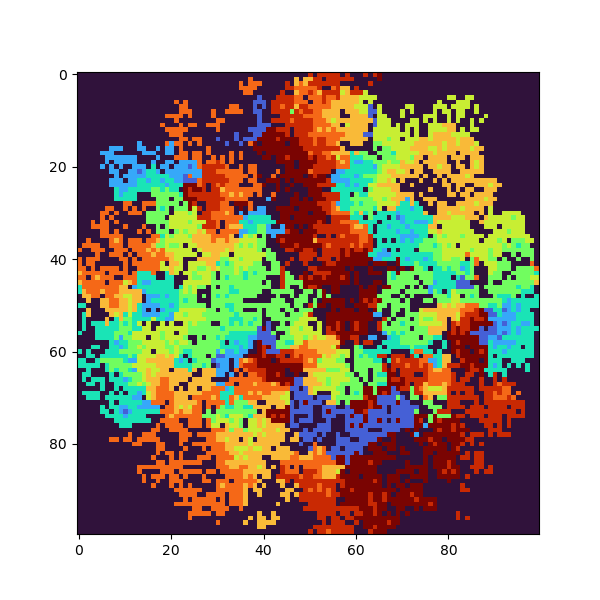

In [16]:

fig, ax = plt.subplots(figsize = (6,6),
                       dpi = 100)
                      
im1=ax.imshow(initLattice, 
                interpolation='none', 
              cmap = cmap
             )

def init():
    im1 = plt.imshow(np.zeros(N,N))
  
    return [im1]

def animate(i):
    
    global lattices
   
    im1.set_array(lattices[i])

    return [im1]
ani = FuncAnimation(fig, animate, frames=nSteps, interval=16,
                    cache_frame_data = True,
                    blit=False
                   )

In [ ]:
[[a for a in range(i,i+3)], [a for a in range(j,j+3)]]

In [ ]:
np.take(lattice, [range(i+j, i+3),range(i+j+1,i+4),range(i+j+2,i+3)], axis = 1, mode='wrap')#[i:i+3, j:j+3].flatten() 


In [ ]:
animate(2)

In [ ]:
fig, ax = plt.subplots(1, 3,
                       figsize = (8,4),
                       dpi = 80,
                        gridspec_kw=dict(width_ratios=[5, 1, 1], 
                     wspace=0.3)
                      )

im1=ax[0].imshow(initLattice, 
                interpolation='none', 
              cmap = cmap
             )

im2=ax[1].bar(x = range(1,1+len(timers)), height = [0.2]*len(timers))
ax[1].set_xticks(range(1,1+len(timers)))

ax[1].set_xticklabels(timers.keys(), rotation = 90)
im3=ax[2].bar(x = range(nSpecies + 1), height = [5]*(nSpecies+1), color = colors)

In [ ]:
N = 4

pDeath = 0.2
wDead = 11
wRepl = 1
wBoost = 100
replMatrix = np.array([[0,1,0],[1,0,1],[0,1,0]])

nSpecies = 3
speciesIds = np.arange(1,nSpecies+1, dtype = int)
cmap = "turbo"
my_cmap = plt.get_cmap(cmap)
colors = my_cmap(np.arange(0,nSpecies)) 


lattice = np.zeros((N,N), dtype = int)
np.random.seed(666)
initDistribution = np.random.choice(speciesIds, size = N*N)
initLattice = initDistribution.reshape(N,N)

def pbc(x):
    global N
    if x >= N:
        return x - N 
    if x < 0:
        return x + N
    else: return x


def countBoosters(s, sBoost, i, j, lat):
    nBoosters = 0
    dIJs = [[-1,0],[1,0],[0,-1],[0,1]] # where is the replication coming from?
    for dI, dJ in dIJs:
        lat

    return nBoosters


lattice = initLattice.astype(int)

In [ ]:
print(lattice)

In [ ]:
for a in range(5):
    print("NEW SIMULATION STEP")
    print(lattice)
    
    
    newLattice = np.zeros((N, N), dtype = int)
    
    r = np.random.uniform(size = (N, N))
    survivedIds = np.logical_and(lattice != 0, r >= pDeath)

    diedIds = np.logical_and(lattice != 0, r < pDeath)
    lattice[diedIds] = 0
    emptyAndReplicatingIds = np.where( # double check this
        np.logical_and(
            #np.logical_or(lattice == 0, diedIds), # empty or just died
            lattice == 0, # just empty
            convolve2d(lattice != 0, replMatrix,
                       mode = "same", boundary="wrap"
                          )
            )
        )
    
    print("lattice after death")
    print(lattice)
    print("REPLICATING IDS:", emptyAndReplicatingIds)
    for i,j in zip(*emptyAndReplicatingIds):
        neighbors = np.pad(lattice, 1, mode='wrap')[i:i+3, j:j+3]
        aliveNeighIds = np.where(neighbors * replMatrix > 0)
        
        print("NEW CELL",i,j, )
        print("considering neighbor matrix:")
        print(neighbors)
        print("of them alive are:")
        print(aliveNeighIds)
        claims = np.zeros(nSpecies+1)
        claims[0] = wDead
        
        for iN,jN in zip(*aliveNeighIds):
            s = neighbors[iN,jN]
            claims[s] += wRepl
            sBoost = s - 1
            if sBoost == 0:
                sBoost = nSpecies
        
            print(f"getting claims from neighbour type {s} at {iN},{jN}, accumulated claims:", claims)

            rotId = dIJs.index((iN,jN))
            boost = (np.rot90(boostMat, k = rotId) * (neighbors == sBoost)).sum()
                
                    

            print(f"boost for species {s} comes from species {sBoost}; \
            checking for boosters around neighbor at [{iN},{jN}]")
            print("boostMat")
            print(boostMats[rotId])
            print("sBoost neigh")
            print(neighbors == sBoost)
            print("boost")
            print((np.rot90(boostMat, k = rotId) * (neighbors == sBoost)).sum())
                    
                    
            claims[s] += wBoost * boost
            print(f"boosted claims:", claims)

        
      #  ax.set_title(nBoosts)
        cumProb = np.cumsum(claims) / claims.sum()
        rr = np.random.uniform()
        newCell = np.argmax(cumProb > rr)
        print(f"claims {claims},cum prob: {cumProb}, rand: {rr}, newCell: {newCell}")
        newLattice[i, j] = newCell

        print("newLattice")
        print(newLattice)
        print("lattice")
        print(lattice)
        print("\n")
    print("newLattice final")
    newLattice[survivedIds] = lattice[survivedIds]

    print(newLattice)
    print("old lattice")
    print(lattice)
    print("died")
    #lattice[diedIds == 0] = 0
    print(lattice)
    lattice = newLattice.copy()
    print("\n")

In [ ]:
bm = [[1, 0, 1],
 [1, 0, 1],
 [0, 0, 0]]

In [ ]:
np.rot90(bm, k = 2)

In [ ]:
lattice[i,j]